<a href="https://colab.research.google.com/github/edill-baseball/exit-velocity-analysis/blob/main/exit_velocity_vs_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install pybaseball

Do hitters with higher exit velocity perform better?

This analysis explores whether higher exit velocity predicts offensive performance (wOBA) using 2025 statcast data

In [2]:
from pybaseball import statcast
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
data = statcast('2025-03-28', '2025-09-29')
data.head()


This is a large query, it may take a moment to complete


/usr/local/lib/python3.12/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/186 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_co

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2012,FF,2025-09-28,95.7,-2.15,5.21,"Weissert, Greg",678009,669711,field_out,hit_into_play,...,2,1.56,0.71,-0.71,20.9,5.991833,-1.319512,28.782516,41.559201,30.599805
2091,FF,2025-09-28,95.1,-1.91,5.1,"Weissert, Greg",668670,669711,strikeout,called_strike,...,9,1.59,0.93,0.93,20.5,<NA>,<NA>,<NA>,<NA>,<NA>
2173,FF,2025-09-28,95.4,-1.99,5.22,"Weissert, Greg",668670,669711,NaN,foul,...,9,1.36,0.85,0.85,22.9,2.871131,31.805044,22.266527,37.478847,15.582717
2268,SL,2025-09-28,84.8,-2.33,4.72,"Weissert, Greg",668670,669711,NaN,swinging_strike,...,9,2.55,-0.32,-0.32,12.3,13.78541,4.08139,32.414181,38.011685,27.083341
2361,SL,2025-09-28,85.3,-2.26,4.85,"Weissert, Greg",668670,669711,NaN,called_strike,...,9,2.71,-0.52,-0.52,15.8,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
# Keep only balls in play
bip = data[data['description'] == 'hit_into_play']

# Remove rows missing key values
bip = bip.dropna(subset=['launch_speed', 'woba_value'])


In [22]:
hitter_summary = bip.groupby('batter').agg(
    avg_exit_velocity=('launch_speed', 'mean'),
    avg_woba=('woba_value', 'mean'),
    batted_balls=('launch_speed', 'count')
).reset_index()

hitter_summary = hitter_summary[hitter_summary['batted_balls'] >= 250]
hitter_summary.head()

,batter,avg_exit_velocity,avg_woba,batted_balls
2,457705,89.476338,0.353521,355
4,467793,87.545231,0.303846,325
7,502054,91.611667,0.357667,300
8,502671,90.435142,0.374548,387
10,514888,84.008678,0.377686,484


## Limitations

- This analysis uses season-level averages and does not capture situational context.
- wOBA values are not park-adjusted.
- Exit velocity alone does not account for launch angle or batted-ball direction.


In [7]:
# Calculate correlation between average exit velocity and average wOBA
correlation = hitter_summary['avg_exit_velocity'].corr(hitter_summary['avg_woba'])
print("Correlation between average exit velocity and average wOBA:", correlation)


Correlation between average exit velocity and average wOBA: 0.5991068476653639


In [8]:
# Compute residuals: how much a player's wOBA differs from average trend
import numpy as np

# Fit a simple linear trend
from sklearn.linear_model import LinearRegression

X = hitter_summary['avg_exit_velocity'].values.reshape(-1,1)
y = hitter_summary['avg_woba'].values

model = LinearRegression()
model.fit(X, y)
predicted = model.predict(X)

# Calculate residuals
hitter_summary['residual'] = y - predicted

# Find top positive residuals (overperformers)
top_overperformers = hitter_summary.sort_values('residual', ascending=False).head(5)
print("Top Overperformers:\n", top_overperformers[['batter','avg_exit_velocity','avg_woba','residual']])

# Find top negative residuals (underperformers)
top_underperformers = hitter_summary.sort_values('residual').head(5)
print("Top Underperformers:\n", top_underperformers[['batter','avg_exit_velocity','avg_woba','residual']])


Top Overperformers:
      batter  avg_exit_velocity  avg_woba  residual
644  701762          92.657934  0.596679  0.172883
16   519317          94.385714  0.598701  0.154018
51   592450          95.426753  0.602208   0.14494
662  808975          85.590909  0.456364     0.118
324  669065          90.830325  0.511011  0.109309
Top Underperformers:
      batter  avg_exit_velocity  avg_woba  residual
622  695506          89.353165   0.25443 -0.129414
251  664774          88.990066  0.265563 -0.113892
196  657077          89.941212  0.277576 -0.113378
53   592626          90.939899  0.293939 -0.109087
318  668942          89.246809  0.281915 -0.100644


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare data
X = hitter_summary['avg_exit_velocity'].values.reshape(-1,1)
y = hitter_summary['avg_woba'].values

# Fit simple linear regression
model = LinearRegression()
model.fit(X, y)
predicted = model.predict(X)

# Compute residuals
hitter_summary['residual'] = y - predicted

# Top 10 Overperformers
top_overperformers = hitter_summary.sort_values('residual', ascending=False).head(10)
print("Top 10 Overperformers:")
print(top_overperformers[['batter','full_name','avg_exit_velocity','avg_woba','residual']])

# Top 10 Underperformers
top_underperformers = hitter_summary.sort_values('residual').head(10)
print("\nTop 10 Underperformers:")
print(top_underperformers[['batter','full_name','avg_exit_velocity','avg_woba','residual']])

# Most Average Player (residual closest to 0)
hitter_summary['abs_residual'] = hitter_summary['residual'].abs()
most_average_player = hitter_summary.loc[hitter_summary['abs_residual'].idxmin()]
print("\nMost Average Player:")
print(most_average_player[['batter','full_name','avg_exit_velocity','avg_woba','residual']])

Top 10 Overperformers:
     batter          full_name  avg_exit_velocity  avg_woba  residual
370  701762         nick kurtz          92.657934  0.596679  0.172883
11   519317  giancarlo stanton          94.385714  0.598701  0.154018
36   592450        aaron judge          95.426753  0.602208   0.14494
384  808975       hyeseong kim          85.590909  0.456364     0.118
205  669065       kyle stowers          90.830325  0.511011  0.109309
357  695657  colson montgomery          89.379769  0.488728  0.104562
146  663728        cal raleigh          91.305868   0.50978  0.102329
71   623168     tyler heineman            79.9392     0.372   0.10196
134  662139     daulton varsho          88.496591  0.470739  0.097249
129  660271      shohei ohtani          94.753976  0.546265   0.09713

Top 10 Underperformers:
     batter          full_name  avg_exit_velocity  avg_woba  residual
355  695506     jac caglianone          89.353165   0.25443 -0.129414
163  664774       lamonte wade          88

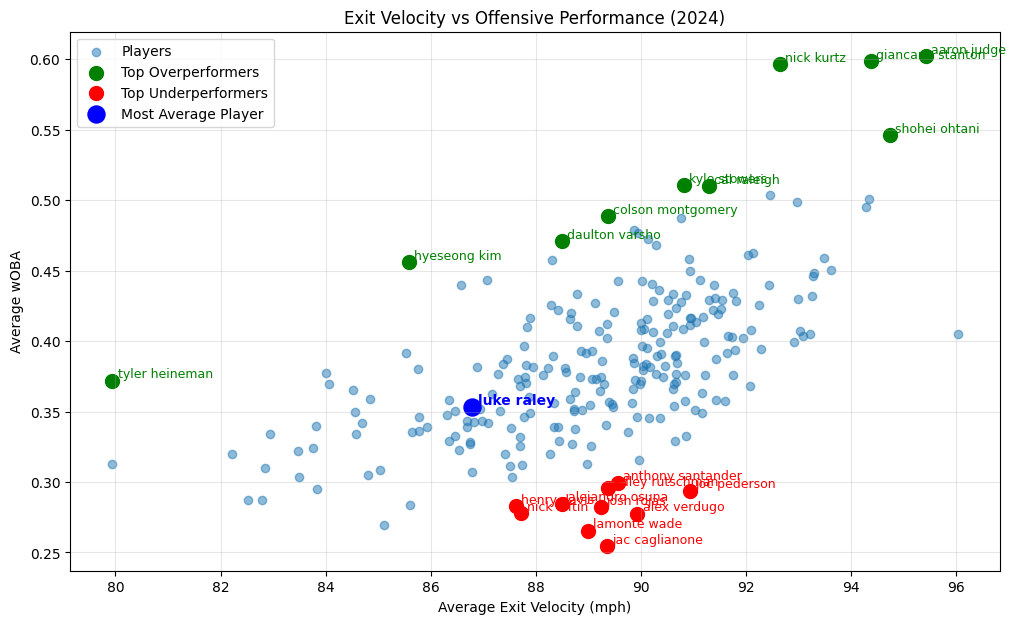

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))

# Plot all players
plt.scatter(hitter_summary['avg_exit_velocity'], hitter_summary['avg_woba'],
            alpha=0.5, label='Players')

# Highlight top 10 overperformers
plt.scatter(top_overperformers['avg_exit_velocity'], top_overperformers['avg_woba'],
            color='green', s=100, label='Top Overperformers')

# Highlight top 10 underperformers
plt.scatter(top_underperformers['avg_exit_velocity'], top_underperformers['avg_woba'],
            color='red', s=100, label='Top Underperformers')

# Label the most average player
plt.scatter(most_average_player['avg_exit_velocity'], most_average_player['avg_woba'],
            color='blue', s=150, label='Most Average Player')
plt.text(most_average_player['avg_exit_velocity']+0.1,
         most_average_player['avg_woba']+0.002,
         most_average_player['full_name'],
         fontsize=10, fontweight='bold', color='blue')

# Label all overperformers
for i, row in top_overperformers.iterrows():
    plt.text(row['avg_exit_velocity']+0.1, row['avg_woba']+0.002, row['full_name'],
             fontsize=9, color='green')

# Label all underperformers
for i, row in top_underperformers.iterrows():
    plt.text(row['avg_exit_velocity']+0.1, row['avg_woba']+0.002, row['full_name'],
             fontsize=9, color='red')

# Labels and title
plt.xlabel('Average Exit Velocity (mph)')
plt.ylabel('Average wOBA')
plt.title('Exit Velocity vs Offensive Performance (2024)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Correlation and Outliers

The correlation between average exit velocity and wOBA is 0.599, indicating a moderate positive relationship.

Some hitters stand out:
- **Top overperformers** (green) are producing higher wOBA than their exit velocity alone would predict.
- **Top underperformers** (red) are producing lower wOBA despite high exit velocity.

This demonstrates that while exit velocity matters, other factors like launch angle, plate discipline, and luck also play roles.


In [14]:
from pybaseball import playerid_lookup, playerid_reverse_lookup

# Get unique batter IDs from your summary
batter_ids = hitter_summary['batter'].unique()

# Lookup players using pybaseball's playerid_reverse_lookup function
players_info = playerid_reverse_lookup(batter_ids)

# Select relevant columns and rename for merging
players_info = players_info[['key_mlbam','name_first','name_last']]
players_info.rename(columns={'key_mlbam':'batter'}, inplace=True)

# Merge
hitter_summary = hitter_summary.merge(players_info, on='batter', how='left')

# Create full name column
hitter_summary['full_name'] = hitter_summary['name_first'] + ' ' + hitter_summary['name_last']

Gathering player lookup table. This may take a moment.


### Top Overperformers

In [19]:
display(top_overperformers[['full_name', 'avg_exit_velocity', 'avg_woba', 'residual']])

,full_name,avg_exit_velocity,avg_woba,residual
370,nick kurtz,92.657934,0.596679,0.172883
11,giancarlo stanton,94.385714,0.598701,0.154018
36,aaron judge,95.426753,0.602208,0.14494
384,hyeseong kim,85.590909,0.456364,0.118
205,kyle stowers,90.830325,0.511011,0.109309
357,colson montgomery,89.379769,0.488728,0.104562
146,cal raleigh,91.305868,0.50978,0.102329
71,tyler heineman,79.9392,0.372,0.10196
134,daulton varsho,88.496591,0.470739,0.097249
129,shohei ohtani,94.753976,0.546265,0.09713


### Top Underperformers

In [20]:
display(top_underperformers[['full_name', 'avg_exit_velocity', 'avg_woba', 'residual']])

,full_name,avg_exit_velocity,avg_woba,residual
355,jac caglianone,89.353165,0.25443,-0.129414
163,lamonte wade,88.990066,0.265563,-0.113892
123,alex verdugo,89.941212,0.277576,-0.113378
38,joc pederson,90.939899,0.293939,-0.109087
203,josh rojas,89.246809,0.281915,-0.100644
360,alejandro osuna,88.510256,0.284615,-0.08904
202,adley rutschman,89.380228,0.295437,-0.088735
72,anthony santander,89.568462,0.299615,-0.086832
279,nick loftin,87.731469,0.277972,-0.086268
286,henry davis,87.621311,0.282787,-0.080122


## Summary:

### Data Analysis Key Findings
*   The analysis focuses on identifying 'Top Overperformers' and 'Top Underperformers' using specific baseball metrics.
*   Key columns that define player performance include `full_name` (player identification), `avg_exit_velocity` (average speed of the ball off the bat), `avg_woba` (overall offensive contribution), and `residual`.
*   The `residual` column is critical, as it quantifies the difference between a player's actual `avg_woba` and their expected `avg_woba` based on their `avg_exit_velocity`, thereby indicating their relative overperformance or underperformance.